In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FangSong']
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
class GrayForecast():
    # initialization
    def __init__(self, data, datacolumn=None):
        if isinstance(data, pd.core.frame.DataFrame):
            self.data = data
            try:
                self.data.columns = ['Data']
            except:
                if not datacolumn:
                    raise Exception('The column of your dataframe is more than 1.')
                else:
                    self.data = pd.DataFrame(data[datacolumn])
                    self.data.columns = ['Data']
        elif isinstance(data, pd.core.series.Series):
            self.data = pd.DataFrame(data, columns=['Data'])
        else:
            self.data = pd.DataFrame(data, columns=['Data'])

        self.forecast_list = self.data.copy()

        if datacolumn:
            self.datacolumn = datacolumn
        else:
            self.datacolumn = None

    # Calibration of stage ratio
    def level_check(self):
        # Data level ratio verification
        n = len(self.data)
        lambda_k = np.zeros(n - 1)
        for i in range(n - 1):
            lambda_k[i] = self.data.ix[i]["Data"] / self.data.ix[i + 1]["Data"]
            if lambda_k[i] < np.exp(-2 / (n + 1)) or lambda_k[i] > np.exp(2 / (n + 2)):
                flag = False
        else:
            flag = True

        self.lambda_k = lambda_k

        if not flag:
            print("Stage ratio verification failed, please translate x (0).")
            return False
        else:
            print("Level ratio verification is successful, please continue.")
            return True

    # GM (1,1) modeling
    def GM_11_build_model(self, forecast=5):
        if forecast > len(self.data):
            raise Exception("You don't have enough data rows.")
        X_0 = np.array(self.forecast_list['Data'].tail(forecast))
        # 1-AGO
        X_1 = np.zeros(X_0.shape)
        for i in range(X_0.shape[0]):
            X_1[i] = np.sum(X_0[0:i + 1])
        # Generation sequence of nearest neighbor mean
        Z_1 = np.zeros(X_1.shape[0] - 1)
        for i in range(1, X_1.shape[0]):
            Z_1[i - 1] = -0.5 * (X_1[i] + X_1[i - 1])

        B = np.append(np.array(np.mat(Z_1).T), np.ones(Z_1.shape).reshape((Z_1.shape[0], 1)), axis=1)
        Yn = X_0[1:].reshape((X_0[1:].shape[0], 1))

        B = np.mat(B)
        Yn = np.mat(Yn)
        a_ = (B.T * B) ** -1 * B.T * Yn

        a, b = np.array(a_.T)[0]

        X_ = np.zeros(X_0.shape[0])

        def f(k):
            return (X_0[0] - b / a) * (1 - np.exp(a)) * np.exp(-a * (k))

        self.forecast_list.loc[len(self.forecast_list)] = f(X_.shape[0])

    # Prediction
    def forecast(self, time=5, forecast_data_len=5):
        for i in range(time):
            self.GM_11_build_model(forecast=forecast_data_len)

    # Print log
    def log(self):
        res = self.forecast_list.copy()
        if self.datacolumn:
            res.columns = [self.datacolumn]
        return res

    # Resetting
    def reset(self):
        self.forecast_list = self.data.copy()

    def plot(self):
        self.forecast_list.plot()
        print(self.forecast_list)
        if self.datacolumn:
            plt.ylabel(self.datacolumn)
            plt.legend([self.datacolumn])
        plt.show()
        
    def getforecast_list(self):
        return self.forecast_list

In [3]:
df = pd.read_csv('C:/Users/Jason/Desktop/data for grey model.csv')
df.head(5)

,Unnamed: 0,Consumption,Income,Production,Savings,Unemployment,Enployment_num
0,0,0.615986,0.972261,-2.452700,4.810312,0.9,100.900000
1,1,0.460376,1.169085,-0.551525,7.287992,0.5,101.404500
2,2,0.876791,1.553271,-0.358708,7.289013,0.5,101.911523
3,3,-0.274245,-0.255272,-2.185455,0.985230,0.7,102.624903
4,4,1.897371,1.987154,1.909734,3.657771,-0.1,102.522278


           Data
0    100.900000
1    101.404500
2    101.911523
3    102.624903
4    102.522278
..          ...
282   97.445707
283   97.406662
284   97.367632
285   97.328616
286   97.289616

[287 rows x 1 columns]


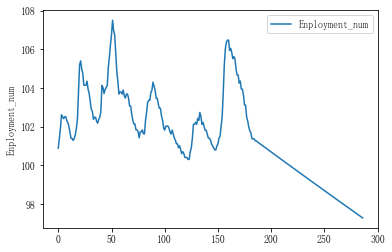

In [4]:
gf = GrayForecast(df, 'Enployment_num')
gf.forecast(100)
gf.log()
gf.plot()

### Improvement
Since the grey prediction is used for short term prediction, so the plan is make a dataset of 50 continuous datapoints, then train the grey model and predict the next value, is the trend is ascend, it means the unemployment rate is negative, which should be assigned -1, and we compare the data with original one to calculated the accuracy.

In [5]:
df = pd.read_csv('C:/Users/Jason/Desktop/data for grey model.csv')

resultlist = []

list_length = 130
for i in range(50):
    train_list = df.iloc[i:list_length+i, 6]
    train_list = np.array(train_list).reshape(-1, 1)
    gf = GrayForecast(train_list, 'Enployment_num')
    gf.forecast(2)
    resultlist.append(gf.getforecast_list())
    gf.log()

print(resultlist)

[           Data
0    100.900000
1    101.404500
2    101.911523
3    102.624903
4    102.522278
..          ...
127  102.129531
128  102.129531
129  102.231661
130  102.587308
131  102.639145

[132 rows x 1 columns],            Data
0    101.404500
1    101.911523
2    102.624903
3    102.522278
4    102.419756
..          ...
127  102.129531
128  102.231661
129  102.129429
130  102.180491
131  102.180439

[132 rows x 1 columns],            Data
0    101.911523
1    102.624903
2    102.522278
3    102.419756
4    102.522176
..          ...
127  102.231661
128  102.129429
129  102.435817
130  102.436005
131  102.538329

[132 rows x 1 columns],            Data
0    102.624903
1    102.522278
2    102.419756
3    102.522176
4    102.522176
..          ...
127  102.129429
128  102.435817
129  102.333381
130  102.435548
131  102.537600

[132 rows x 1 columns],            Data
0    102.522278
1    102.419756
2    102.522176
3    102.522176
4    102.317131
..          ...
127  102.435817
128

In [6]:
type(resultlist[0])

pandas.core.frame.DataFrame

In [7]:
listaccu = []
for i in range(len(resultlist)-1):
    single_list = resultlist[i]
    last_1st = single_list.iloc[131, 0]
    last_2nd = single_list.iloc[130, 0]
    real_data = single_list.iloc[129, 0]
    future_real_data = resultlist[i+1].iloc[129, 0]
    if last_1st > last_2nd:  # predict decrease
        if real_data > future_real_data:  # real decrease
            listaccu.append(-1)
        else:
            listaccu.append(1)
    elif last_1st < last_2nd:  # predict increase
        if real_data < future_real_data:  # real increase
            listaccu.append(-1)
        else:
            listaccu.append(1)

In [20]:
test = listaccu
test = np.array(test)
test

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1,
       -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1])

In [9]:
frequ = 0
for i in range(len(listaccu)):
    if listaccu[i] == 1:
        frequ = frequ + 1
print("The accuracy of grey model trained by last 130 days is", frequ/len(listaccu))

The accuracy of grey model trained by last 130 days is 0.7551020408163265


In [10]:
df = pd.read_csv('C:/Users/Jason/Desktop/data for grey model.csv')

resultlist = []

list_length = 30
for i in range(150):
    train_list = df.iloc[i:list_length+i, 6]
    train_list = np.array(train_list).reshape(-1, 1)
    gf = GrayForecast(train_list, 'Enployment_num')
    gf.forecast(2)
    resultlist.append(gf.getforecast_list())
    gf.log()

listaccu = []
for i in range(len(resultlist)-1):
    single_list = resultlist[i]
    last_1st = single_list.iloc[31, 0]
    last_2nd = single_list.iloc[30, 0]
    real_data = single_list.iloc[29, 0]
    future_real_data = resultlist[i+1].iloc[29, 0]
    if last_1st > last_2nd:  # predict increase
        if real_data > future_real_data:  # real decrease
            listaccu.append(-1)
        else:
            listaccu.append(1)
    elif last_1st < last_2nd:  # predict decrease
        if real_data < future_real_data:  # real increase
            listaccu.append(-1)
        else:
            listaccu.append(1)

In [11]:
frequ = 0
for i in range(len(listaccu)):
    if listaccu[i] == 1:
        frequ = frequ + 1
print("The accuracy of grey model trained by last 30 days is", frequ/len(listaccu))

The accuracy of grey model trained by last 30 days is 0.7315436241610739


In [12]:
df = pd.read_csv('C:/Users/Jason/Desktop/data for grey model.csv')

resultlist = []

list_length = 50
for i in range(130):
    train_list = df.iloc[i:list_length+i, 6]
    train_list = np.array(train_list).reshape(-1, 1)
    gf = GrayForecast(train_list, 'Enployment_num')
    gf.forecast(2)
    resultlist.append(gf.getforecast_list())
    gf.log()

listaccu = []
for i in range(len(resultlist)-1):
    single_list = resultlist[i]
    last_1st = single_list.iloc[51, 0]
    last_2nd = single_list.iloc[50, 0]
    real_data = single_list.iloc[49, 0]
    future_real_data = resultlist[i+1].iloc[49, 0]
    if last_1st > last_2nd:  # predict increase
        if real_data > future_real_data:  # real decrease
            listaccu.append(-1)
        else:
            listaccu.append(1)
    elif last_1st < last_2nd:  # predict decrease
        if real_data < future_real_data:  # real increase
            listaccu.append(-1)
        else:
            listaccu.append(1)
    
frequ = 0
for i in range(len(listaccu)):
    if listaccu[i] == 1:
        frequ = frequ + 1
print("The accuracy of grey model trained by last 50 days is", frequ/len(listaccu))

The accuracy of grey model trained by last 50 days is 0.7441860465116279


In [13]:
df = pd.read_csv('C:/Users/Jason/Desktop/data for grey model.csv')

resultlist = []

list_length = 150
for i in range(30):
    train_list = df.iloc[i:list_length+i, 6]
    train_list = np.array(train_list).reshape(-1, 1)
    gf = GrayForecast(train_list, 'Enployment_num')
    gf.forecast(2)
    resultlist.append(gf.getforecast_list())
    gf.log()

listaccu = []
for i in range(len(resultlist)-1):
    single_list = resultlist[i]
    last_1st = single_list.iloc[151, 0]
    last_2nd = single_list.iloc[150, 0]
    real_data = single_list.iloc[149, 0]
    future_real_data = resultlist[i+1].iloc[149, 0]
    if last_1st > last_2nd:  # predict increase
        if real_data > future_real_data:  # real decrease
            listaccu.append(-1)
        else:
            listaccu.append(1)
    elif last_1st < last_2nd:  # predict decrease
        if real_data < future_real_data:  # real increase
            listaccu.append(-1)
        else:
            listaccu.append(1)
    
frequ = 0
for i in range(len(listaccu)):
    if listaccu[i] == 1:
        frequ = frequ + 1
print("The accuracy of grey model trained by last 150 days is", frequ/len(listaccu))

The accuracy of grey model trained by last 150 days is 0.8275862068965517


In [21]:
df = pd.read_csv('C:/Users/Jason/Desktop/data for grey model.csv')

resultlist = []

list_length = 170
for i in range(10):
    train_list = df.iloc[i:list_length+i, 6]
    train_list = np.array(train_list).reshape(-1, 1)
    gf = GrayForecast(train_list, 'Enployment_num')
    gf.forecast(2)
    resultlist.append(gf.getforecast_list())
    gf.log()

listaccu = []
for i in range(len(resultlist)-1):
    single_list = resultlist[i]
    last_1st = single_list.iloc[171, 0]
    last_2nd = single_list.iloc[170, 0]
    real_data = single_list.iloc[169, 0]
    future_real_data = resultlist[i+1].iloc[169, 0]
    if last_1st > last_2nd:  # predict increase
        if real_data > future_real_data:  # real decrease
            listaccu.append(-1)
        else:
            listaccu.append(1)
    elif last_1st < last_2nd:  # predict decrease
        if real_data < future_real_data:  # real increase
            listaccu.append(-1)
        else:
            listaccu.append(1)
    
frequ = 0
for i in range(len(listaccu)):
    if listaccu[i] == 1:
        frequ = frequ + 1
print("The accuracy of grey model trained by last 170 days is", frequ/len(listaccu))

The accuracy of grey model trained by last 170 days is 0.8888888888888888


In [23]:
df = pd.read_csv('C:/Users/Jason/Desktop/data for grey model.csv')

resultlist = []

list_length = 100
for i in range(80):
    train_list = df.iloc[i:list_length+i, 6]
    train_list = np.array(train_list).reshape(-1, 1)
    gf = GrayForecast(train_list, 'Enployment_num')
    gf.forecast(2)
    resultlist.append(gf.getforecast_list())
    gf.log()

listaccu = []
for i in range(len(resultlist)-1):
    single_list = resultlist[i]
    last_1st = single_list.iloc[101, 0]
    last_2nd = single_list.iloc[100, 0]
    real_data = single_list.iloc[99, 0]
    future_real_data = resultlist[i+1].iloc[99, 0]
    if last_1st > last_2nd:  # predict increase
        if real_data > future_real_data:  # real decrease
            listaccu.append(-1)
        else:
            listaccu.append(1)
    elif last_1st < last_2nd:  # predict decrease
        if real_data < future_real_data:  # real increase
            listaccu.append(-1)
        else:
            listaccu.append(1)
    
frequ = 0
for i in range(len(listaccu)):
    if listaccu[i] == 1:
        frequ = frequ + 1
print("The accuracy of grey model trained by last 100 days is", frequ/len(listaccu))

The accuracy of grey model trained by last 100 days is 0.7468354430379747


In [25]:
df = pd.read_csv('C:/Users/Jason/Desktop/data for grey model.csv')

resultlist = []

list_length = 140
for i in range(40):
    train_list = df.iloc[i:list_length+i, 6]
    train_list = np.array(train_list).reshape(-1, 1)
    gf = GrayForecast(train_list, 'Enployment_num')
    gf.forecast(2)
    resultlist.append(gf.getforecast_list())
    gf.log()

listaccu = []
for i in range(len(resultlist)-1):
    single_list = resultlist[i]
    last_1st = single_list.iloc[141, 0]
    last_2nd = single_list.iloc[140, 0]
    real_data = single_list.iloc[139, 0]
    future_real_data = resultlist[i+1].iloc[139, 0]
    if last_1st > last_2nd:  # predict increase
        if real_data > future_real_data:  # real decrease
            listaccu.append(-1)
        else:
            listaccu.append(1)
    elif last_1st < last_2nd:  # predict decrease
        if real_data < future_real_data:  # real increase
            listaccu.append(-1)
        else:
            listaccu.append(1)
    
frequ = 0
for i in range(len(listaccu)):
    if listaccu[i] == 1:
        frequ = frequ + 1
print("The accuracy of grey model trained by last 140 days is", frequ/len(listaccu))

The accuracy of grey model trained by last 140 days is 0.8461538461538461


In [26]:
df = pd.read_csv('C:/Users/Jason/Desktop/data for grey model.csv')

resultlist = []

list_length = 160
for i in range(20):
    train_list = df.iloc[i:list_length+i, 6]
    train_list = np.array(train_list).reshape(-1, 1)
    gf = GrayForecast(train_list, 'Enployment_num')
    gf.forecast(2)
    resultlist.append(gf.getforecast_list())
    gf.log()

listaccu = []
for i in range(len(resultlist)-1):
    single_list = resultlist[i]
    last_1st = single_list.iloc[161, 0]
    last_2nd = single_list.iloc[160, 0]
    real_data = single_list.iloc[159, 0]
    future_real_data = resultlist[i+1].iloc[159, 0]
    if last_1st > last_2nd:  # predict increase
        if real_data > future_real_data:  # real decrease
            listaccu.append(-1)
        else:
            listaccu.append(1)
    elif last_1st < last_2nd:  # predict decrease
        if real_data < future_real_data:  # real increase
            listaccu.append(-1)
        else:
            listaccu.append(1)
    
frequ = 0
for i in range(len(listaccu)):
    if listaccu[i] == 1:
        frequ = frequ + 1
print("The accuracy of grey model trained by last 160 days is", frequ/len(listaccu))

The accuracy of grey model trained by last 160 days is 0.7368421052631579


Accuracy: 

170 days: 0.8888888888888888

150 days: 0.8275862068965517

140 days: 0.8461538461538461

130 days: 0.7551020408163265

110 days: 0.7681159420289855

100 days: 0.7468354430379747

50 days: 0.7441860465116279

30 days: 0.7315436241610739

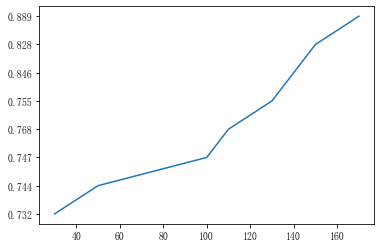

In [32]:
import matplotlib.pyplot as plt
x_data = ['0.732','0.744','0.747','0.768','0.755','0.846','0.828','0.889']
y_data = [30,50,100,110,130,140,150,170]
plt.plot(y_data,x_data)
plt.show()

In [16]:
def accuracy_calculation(train_length):
    resultlist = []

    list_length = 180
    for i in range(180-train_length):
        train_list = df.iloc[i:list_length+i, 6]
        train_list = np.array(train_list).reshape(-1, 1)
        gf = GrayForecast(train_list, 'Enployment_num')
        gf.forecast(2)
        resultlist.append(gf.getforecast_list())
        gf.log()

    listaccu = []
    for i in range(len(resultlist)-1):
        single_list = resultlist[i]
        last_1st = single_list.iloc[train_length+1, 0]
        last_2nd = single_list.iloc[train_length, 0]
        real_data = single_list.iloc[train_length-1, 0]
        future_real_data = resultlist[i+1].iloc[train_length-1, 0]
        if last_1st > last_2nd:  # predict increase
            if real_data > future_real_data:  # real decrease
                listaccu.append(-1)
            else:
                listaccu.append(1)
        elif last_1st < last_2nd:  # predict decrease
            if real_data < future_real_data:  # real increase
                listaccu.append(-1)
            else:
                listaccu.append(1)

    frequ = 0
    for i in range(len(listaccu)):
        if listaccu[i] == 1:
            frequ = frequ + 1
    print("The accuracy of grey model trained by last", train_length, " days is", frequ/len(listaccu))

In [17]:
df = pd.read_csv('C:/Users/Jason/Desktop/data for grey model.csv')
for i in range(180):
    accuracy_calculation(i)

The accuracy of grey model trained by last 0  days is 0.98
The accuracy of grey model trained by last 1  days is 0.7516778523489933
The accuracy of grey model trained by last 2  days is 0.75
The accuracy of grey model trained by last 3  days is 0.7482993197278912
The accuracy of grey model trained by last 4  days is 0.7534246575342466
The accuracy of grey model trained by last 5  days is 0.7517241379310344
The accuracy of grey model trained by last 6  days is 0.7569444444444444
The accuracy of grey model trained by last 7  days is 0.7569444444444444
The accuracy of grey model trained by last 8  days is 0.7552447552447552
The accuracy of grey model trained by last 9  days is 0.7535211267605634
The accuracy of grey model trained by last 10  days is 0.75177304964539
The accuracy of grey model trained by last 11  days is 0.75
The accuracy of grey model trained by last 12  days is 0.7482014388489209
The accuracy of grey model trained by last 13  days is 0.7482014388489209
The accuracy of gr

ZeroDivisionError: division by zero